# Pipeline Suitability Analysis

This notebook demonstrates the workflow for finding optimal pipeline paths using geospatial suitability analysis. The analysis consists of:

1. Loading raster factors and reference paths
2. Creating cost maps with weighted factors
3. Finding least cost paths between points
4. Comparing predicted paths with reference paths
5. Optimizing weights to improve path prediction

## Setup and Import Libraries

In [31]:
import psutil
print(f"Available RAM: {psutil.virtual_memory().available / (1024**3):.2f} GB")

Available RAM: 1.91 GB


In [2]:
# Import required libraries
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
import numpy as np
warnings.filterwarnings('ignore')

# Import our custom pipeline analysis modules
from pipefit.data_loader import DataLoader, load_reference_path
from pipefit.cost_map import CostMapGenerator
from pipefit.path_finder import LeastCostPathFinder
from pipefit.path_evaluator import PathEvaluator

## 1. Load Dataset

First, we'll load a dataset containing raster factors and reference path.

In [48]:
# Set the path to your dataset folder
dataset_path = "datasets/vankor_1k_1k_pixel"#"datasets/roi1_600k_300k_meters"

# Define a factor mapping (optional)
factor_mapping = {
    # Map filename to standardized name      
    'protectedMask.tif': 'protected_areas',
    'inverted_urban_zones.tif': 'proximity_to_cities',
    'slopeSuitability.tif': 'slope',
    'railwayMask.tif': 'railways',
    'riversMask.tif': 'rivers',
    'wetlandMask.tif': 'wetlands',
    'wetland1Mask.tif': 'wetlands1',
    'wetland2Mask.tif': 'wetlands2',
    'highwayMask.tif': 'highway',
}

# Create a data loader and load the data
data_loader = DataLoader(dataset_path)
data_loader.load_data(factor_mapping=factor_mapping)

# Load reference path separately
reference_path_dir = os.path.join(dataset_path, 'reference')
reference_path = load_reference_path(reference_path_dir)

Loaded 9 raster factors: ['highway', 'proximity_to_cities', 'protected_areas', 'railways', 'rivers', 'slope', 'wetlands1', 'wetlands2', 'wetlands']
Loaded reference path from datasets/vankor_1k_1k_pixel\reference\pipe.geojson


In [4]:
# for i in data_loader.factors:
#     data_loader.factors[i] = data_loader.factors[i].astype(uint8)

In [5]:
# Изменяю фактор protectedMask
# data_loader.factors['protected_areas'][data_loader.factors['protected_areas'] == 0] = 255 #np.inf - нельзя так как uint8
# data_loader.factors['protected_areas'][data_loader.factors['protected_areas'] == 1] = 0

## 2. Visualize Input Factors

Let's examine the normalized raster factors that we'll use to create the cost map.

In [23]:
# Create a cost map generator
cost_generator = CostMapGenerator(data_loader.factors)

In [ ]:
# Visualize all input factors
cost_generator.visualize_factors(figsize=(15, 10))

## 3. Generate Cost Map

Now we'll create a cost map by combining factors with weights. The weights reflect the relative importance of each factor in determining pipeline suitability.

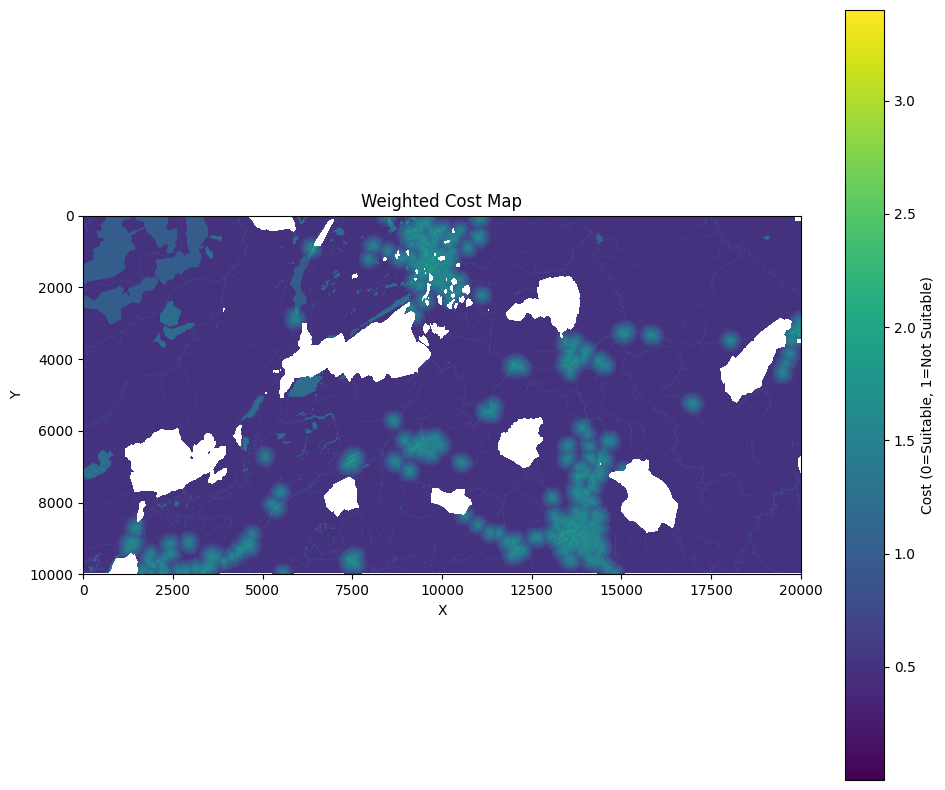

Saved raster to datasets/roi1_600k_300k_meters\results\cost_map.tif


In [24]:
# Define weights for each factor
# These can be different from the factor names in the data files
weights = {
#    'protected_areas': 1,
    'highway': 0.6,   
    'proximity_to_cities': 1, 
    'slope': 1,
    'railways': 0.6,          
    'rivers': 0.7,        
    'wetlands': 0.7,
    'wetlands1': 0.5,
    'wetlands2': 0.9,      
}

# # Optional: Define a weight-to-factor mapping if your weight keys don't match factor names
weight_mapping = None  # We're using standardized names, so no mapping needed

# Generate cost map with default weight for any missing factors
cost_map = cost_generator.generate_cost_map(
    weights=weights,
    default_weight=1,  # Any factors without explicit weights get this value
    weight_mapping=weight_mapping
)

# Замена 0 на inf
cost_map[cost_map == 0] = np.inf

# Visualize cost map
cost_generator.visualize_cost_map(cost_map, title="Weighted Cost Map")

# Save cost map (optional)
cost_map_path = os.path.join(dataset_path, 'results', 'cost_map.tif')
os.makedirs(os.path.dirname(cost_map_path), exist_ok=True)
data_loader.save_raster(cost_map, cost_map_path)

In [8]:
# cost_map.min()

## 4. Find Least Cost Path

Using the cost map, we'll find the least cost path between start and end points.

Start point: (9996, 578), End point: (3327, 19929)
Path found with total cost: 14188.370131842079


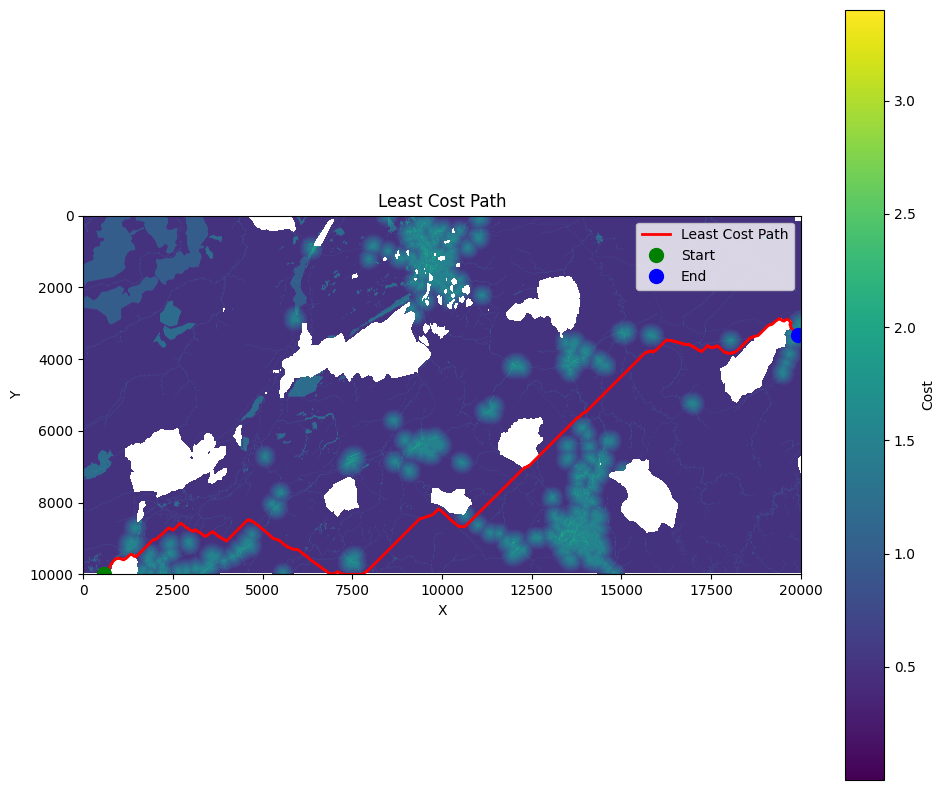

In [25]:
# Define start and end points
# Option 1: Define using geographical coordinates


start_x, start_y = 9187144, 7397263#8536880, 9502543  # Example coordinates (replace with actual coordinates)
end_x, end_y = 9767670, 7597333 #8563026, 9496811 #8832995, 9632587     # Example coordinates (replace with actual coordinates) 8831023, 9630540

# # Convert to raster indices
start_indices = data_loader.coordinates_to_indices(start_x, start_y)
end_indices = data_loader.coordinates_to_indices(end_x, end_y)

# Option 2: Define directly as raster indices
#start_indices = (12000, 100)   # Example indices (row, col) (replace with actual indices) (5381, 0) to (0, 10925)
#end_indices = (10000, 2500)    # Example indices (row, col) (replace with actual indices) -на границе падало ядро

# Option 3: Use default start/end points (lower left to upper right)
#start_indices = None # None Will use lower left corner
#end_indices = None    # Will use upper right corner

print(f"Start point: {start_indices}, End point: {end_indices}")

# Create path finder (no need to pass transform/crs at initialization)
path_finder = LeastCostPathFinder(cost_map)

# Get metadata for later use
metadata = data_loader.get_common_metadata()

# Find least cost path using A* algorithm (default)
path_indices, path_cost = path_finder.find_path(
    start_indices, 
    end_indices, 
    method='astar',  # 'astar' or 'dijkstra'
    fully_connected=True  # Use 8-connected neighbors
)
print(f"Path found with total cost: {path_cost}")

# Visualize path on cost map
path_finder.visualize_path(path_indices, start_indices, end_indices)

# Convert path to GeoDataFrame (pass transform and crs here)
path_gdf = path_finder.path_to_geodataframe(
    path_indices, 
    path_cost, 
    transform=metadata['transform'], 
    crs=metadata['crs']
)

# Save path (optional)
path_output = os.path.join(dataset_path, 'results', 'least_cost_path.geojson')
path_gdf.to_file(path_output)

## 5. Compare with Reference Path

Now we'll compare our predicted path with the reference (ground truth) path and calculate similarity metrics.

Path Comparison Metrics:
hausdorff_distance: 82988.9252
average_min_distance: 35898.9237
buffer_overlap: 0.0011
path_length_ratio: 1.0618
combined_score: 0.7997


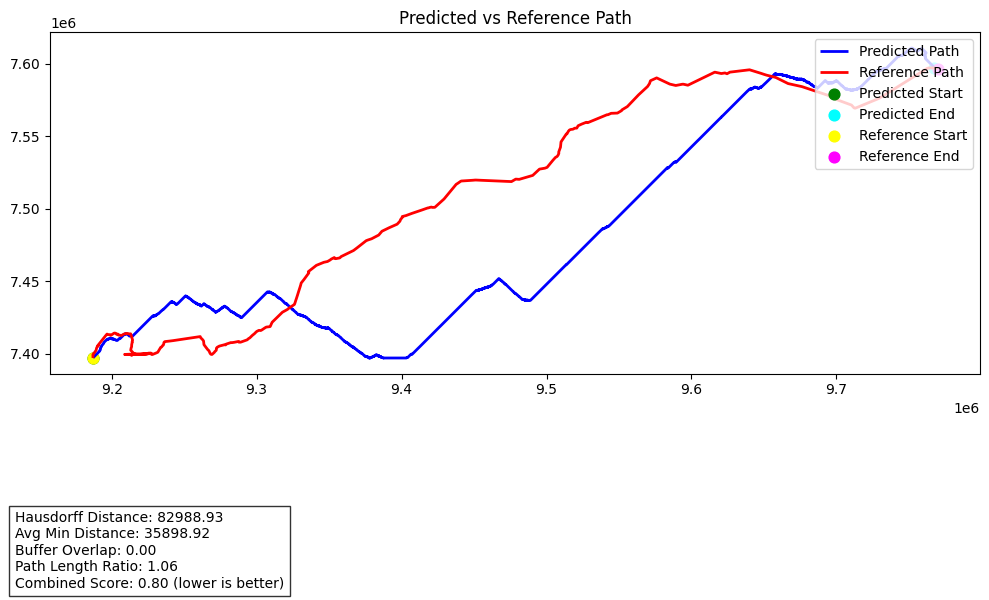

In [28]:
# Create path evaluator with reference path passed explicitly
evaluator = PathEvaluator(
    predicted_path=path_indices,
    reference_path=reference_path,  # Pass the reference path directly
    transform=metadata['transform'],
    crs=metadata['crs']
)

# Calculate all metrics
metrics = evaluator.evaluate_all_metrics(buffer_distance=100)  # Adjust buffer distance as needed

# Display metrics
print("Path Comparison Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

# Visualize paths with metrics
evaluator.visualize_paths(title="Predicted vs Reference Path", buffer_distance=100)

# Genetic algorithm - вариант с обучением на одном изображении

In [10]:
import random
from prettytable import PrettyTable #python -m pip install prettytable

In [11]:
def fitness_function(factors, params, start_indices, end_indices, reference_path, metadata):

    cost_generator = CostMapGenerator(factors)
    weight_mapping = None
    cost_map = cost_generator.generate_cost_map(weights=params, default_weight=None, weight_mapping=weight_mapping)
    cost_map[cost_map == 0] = np.inf

    path_finder = LeastCostPathFinder(cost_map)
    path_indices, path_cost = path_finder.find_path(start_indices, end_indices, method='astar',  fully_connected=True)

    evaluator = PathEvaluator(predicted_path=path_indices, reference_path=reference_path, 
                              transform=metadata['transform'],
                              crs=metadata['crs'])
    
    metrics = evaluator.calculate_buffer_overlap(buffer_distance = 100)

    return metrics

def create_initial_population(size, lower_bound, upper_bound): # стартовые веса
    population = []
    for _ in range(size):
        

        weights = { # не прописываю protected_areas - они всегда имеют коэфф 1
            'highway': 0.6,   
            'proximity_to_cities': 1, 
            'slope': 1,
            'railways': 0.6,          
            'rivers': 0.7,        
            'wetlands': 0.7,
            'wetlands1': 0.5,
            'wetlands2': 0.9,  
        # 'highway': random.uniform(lower_bound, upper_bound),   
        # 'proximity_to_cities': random.uniform(lower_bound, upper_bound), 
        # 'slope': random.uniform(lower_bound, upper_bound),
        # 'railways': random.uniform(lower_bound, upper_bound),          
        # 'rivers': random.uniform(lower_bound, upper_bound),        
        # 'wetlands': random.uniform(lower_bound, upper_bound),
        # 'wetlands1': random.uniform(lower_bound, upper_bound),
        # 'wetlands2': random.uniform(lower_bound, upper_bound),      
        }
        individual = (weights)
        population.append(individual)

    return population

# Selection function using tournament selection
def selection(population, fitnesses, tournament_size=5):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(zip(population, fitnesses)), tournament_size)
        winner = max(tournament, key=lambda x: x[1])[0]
        selected.append(winner)
    return selected

# Crossover function
def crossover(parent1, parent2):
    alpha = random.random()
    child1 = {}
    child2 = {}
    
    #Проверка, что ключи совпадают
    # if parent1.keys() != parent2.keys():
    #     raise ValueError("Родители должны иметь одинаковые ключи")
    
    # Переписала через цикл, так как веса решила задавать словарем вместо массива
    for key in parent1:
        child1[key] = alpha * parent1[key] + (1 - alpha) * parent2[key]
        child2[key] = alpha * parent2[key] + (1 - alpha) * parent1[key]
    return child1, child2

# Mutation function
def mutation(individual, mutation_rate, lower_bound, upper_bound):
    mutated = individual.copy()
    
    for param in mutated:
        if random.random() < mutation_rate:
            
            mutation_amount = random.uniform(-1, 1)
            mutated[param] += mutation_amount

            mutated[param] = max(min(mutated[param], upper_bound), lower_bound)


    return mutated

# Main genetic algorithm function
def genetic_algorithm(factors, population_size, lower_bound, upper_bound, generations, mutation_rate, start_indices, end_indices, reference_path, metadata):
    population = create_initial_population(population_size, lower_bound, upper_bound)

    best_performers = []
    all_populations = []
    worst_fitness = []

    # Prepare for table
    table = PrettyTable()
    table.field_names = ["Generation", 'highway', 'proximity_to_cities',
                          'slope','railways','rivers','wetlands','wetlands1','wetlands2',
                          "Fitness"]

    for generation in range(generations):
        #print('Generation №: ', generation)

        fitnesses = [fitness_function(factors, ind, start_indices, end_indices, reference_path, metadata) for ind in population]
        
        # Store the best performer of the current generation
        best_idx = np.argmax(fitnesses)
        best_fitness = max(fitnesses)
        worst_fitness = min(fitnesses)
        best_individual = population[best_idx]
        best_performers.append((best_individual, max(fitnesses)))
        all_populations.append(population[:])
        table.add_row([generation + 1,
                        best_individual['highway'], best_individual['proximity_to_cities'], 
                        best_individual['slope'], best_individual['railways'], 
                        best_individual['rivers'], best_individual['wetlands'],
                        best_individual['wetlands1'], best_individual['wetlands2'],  
                        best_fitness])

        population = selection(population, fitnesses)

        next_population = []
        for i in range(0, len(population), 2):
            parent1 = population[i]
            parent2 = population[i + 1]

            crossover(parent1, parent2)
            child1, child2 = crossover(parent1, parent2)
            next_population.append(mutation(child1, mutation_rate, lower_bound, upper_bound))
            next_population.append(mutation(child2, mutation_rate, lower_bound, upper_bound))

            
        #Replace the old population with the new one, preserving the best individual
        next_population[0] = best_individual
        population = next_population

    return population[np.argmax(fitnesses)], table, all_populations, best_individual, best_performers, worst_fitness

In [12]:
# Вынесла вывод после ГА в отдельную функцию
def visualize_ga_results(table, all_populations, best_individual, generations, best_performers, worst_fitness):

    print(table)

    fig, axs = plt.subplots(2, 4, figsize=(30, 10))

    # Последнее поколение значения весов фавторов
    final_population = all_populations[-1]
    
    factors_list = ['highway', 'proximity_to_cities','slope','railways','rivers','wetlands','wetlands1','wetlands2']# сожно достать и из ind
    
    axs = axs.flatten()
    for i, el in enumerate(factors_list):
        axs[i].scatter(range(len(final_population)), [ind[el] for ind in final_population], color='blue', label=el)
        axs[i].scatter([final_population.index(best_individual)], [best_individual[el]], color='cyan', s=100, label='Best Individual {}'.format(el))
        axs[i].set_title(el, fontweight='bold')
        if i==0 or i==4:
            axs[i].set_ylabel('weight', fontsize=12)
        if i>=4:
            axs[i].set_xlabel('population', fontsize=12)
    
        #axs[i].set_ylabel(el, color='blue')
        #axs[i].legend(loc='upper left', bbox_to_anchor=(1, 1))  # Выношу легенду за пределы графика

    # for i, el in enumerate(factors_list):
    #     axs[i].scatter(range(len(final_population)), [ind[el] for ind in final_population], color='blue', label=el)
    #     axs[i].scatter([final_population.index(best_individual)], [best_individual[el]], color='cyan', s=100, label='Best Individual {}'.format(el))
    #     axs[i].set_ylabel(el, color='blue')
    #     axs[i].legend(loc='upper left', bbox_to_anchor=(1, 1))  # Выношу легенду за пределы графика


    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='Все особи'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='cyan', markersize=10, label='Лучшая особь')
    ]
    fig.legend(handles=legend_elements, 
           loc='upper center', 
           bbox_to_anchor=(0.5, 1.02),  # Размещаем над графиками
           ncol=2, fontsize=12)

    plt.tight_layout()

    fig.suptitle(f'Final Generation ({generations}) Population Solutions', fontsize=18, fontweight='bold', y=1.05)
    #axs[0].set_title(f'Final Generation ({generations}) Population Solutions')

    
   # Значения каждого параметра
    generations_list = range(1, len(best_performers) + 1)

    fig, ax = plt.subplots()
    
    colors_list = ['blue', 'green', 'red', 'purple', 'olive', 'gold', 'silver', 'indigo']
    for i, el in enumerate(factors_list):
        ax.plot(generations_list, [ind[0][el] for ind in best_performers], label=el, color=colors_list[i])

    ax.set_xlabel('Generation')
    ax.set_ylabel('Parameter Values')
    ax.set_title('Parameter Values Over Generations')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Значение метрики по поколениям 
    best_fitness_values = [fit[1] for fit in best_performers]
    min_fitness_values = worst_fitness
    max_fitness_values = best_fitness_values
    
    fig, ax = plt.subplots()
    ax.plot(generations_list, best_fitness_values, label='Best Fitness', color='black')
    ax.fill_between(generations_list, min_fitness_values, max_fitness_values, color='gray', alpha=0.5, label='Fitness Range')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness')
    ax.set_title('Fitness Over Generations')
    ax.legend(loc='upper left')

    plt.show()

In [ ]:
dataset_path = "datasets/interest_area" # датасет, который охватывают весь путь обучающей трубы
# Используемый датасет тестовый - "datasets/vankor_1k_1k_pixel" - то на чем проверяла работу

factor_mapping = {    
    'protectedMask.tif': 'protected_areas',
    'inverted_urban_zones.tif': 'proximity_to_cities',
    'slopeSuitability.tif': 'slope',
    'railwayMask.tif': 'railways',
    'riversMask.tif': 'rivers',
    'wetlandMask.tif': 'wetlands',
    'wetland1Mask.tif': 'wetlands1',
    'wetland2Mask.tif': 'wetlands2',
    'highwayMask.tif': 'highway',
}

data_loader = DataLoader(dataset_path)
data_loader.load_data(factor_mapping=factor_mapping)

start_x, start_y = 9167986, 7388294 # 8536880, 9502543 - для ванкора
end_x, end_y = 11568914, 6894631 # 8563026, 9496811- для ванкора

start_indices = data_loader.coordinates_to_indices(start_x, start_y)
end_indices = data_loader.coordinates_to_indices(end_x, end_y)

reference_path_dir = os.path.join(dataset_path, 'reference')
reference_path = load_reference_path(reference_path_dir)
metadata = data_loader.get_common_metadata()

Loaded 9 raster factors: ['highway', 'proximity_to_cities', 'protected_areas', 'railways', 'rivers', 'slope', 'wetlands1', 'wetlands2', 'wetlands']
Loaded reference path from datasets/vankor_1k_1k_pixel\reference\pipe.geojson


In [14]:
# Параметры ГА
population_size = 50 # Должно быть четным так как шаг 2 при создании потомков
lower_bound = 0.000001
upper_bound = 1
generations = 5
mutation_rate = 1

# Run the genetic algorithm
best_solution, table, all_populations, best_individual, best_performers, worst_fitness = genetic_algorithm(data_loader.factors, population_size, lower_bound, upper_bound, generations, mutation_rate, start_indices, end_indices, reference_path, metadata)
print(best_solution)

{'highway': 1, 'proximity_to_cities': 0.41156024524946355, 'slope': 1, 'railways': 0.6381650268410456, 'rivers': 0.33029083240093216, 'wetlands': 1, 'wetlands1': 1e-06, 'wetlands2': 0.08005886525440364}


+------------+---------+---------------------+-------+--------------------+---------------------+----------+-----------+---------------------+----------------------+
| Generation | highway | proximity_to_cities | slope |      railways      |        rivers       | wetlands | wetlands1 |      wetlands2      |       Fitness        |
+------------+---------+---------------------+-------+--------------------+---------------------+----------+-----------+---------------------+----------------------+
|     1      |   0.6   |          1          |   1   |        0.6         |         0.7         |   0.7    |    0.5    |         0.9         | 0.004988007634337018 |
|     2      |    1    | 0.41156024524946355 |   1   | 0.6381650268410456 | 0.33029083240093216 |    1     |   1e-06   | 0.08005886525440364 | 0.05714668948561461  |
|     3      |    1    | 0.41156024524946355 |   1   | 0.6381650268410456 | 0.33029083240093216 |    1     |   1e-06   | 0.08005886525440364 | 0.05714668948561461  |
|   

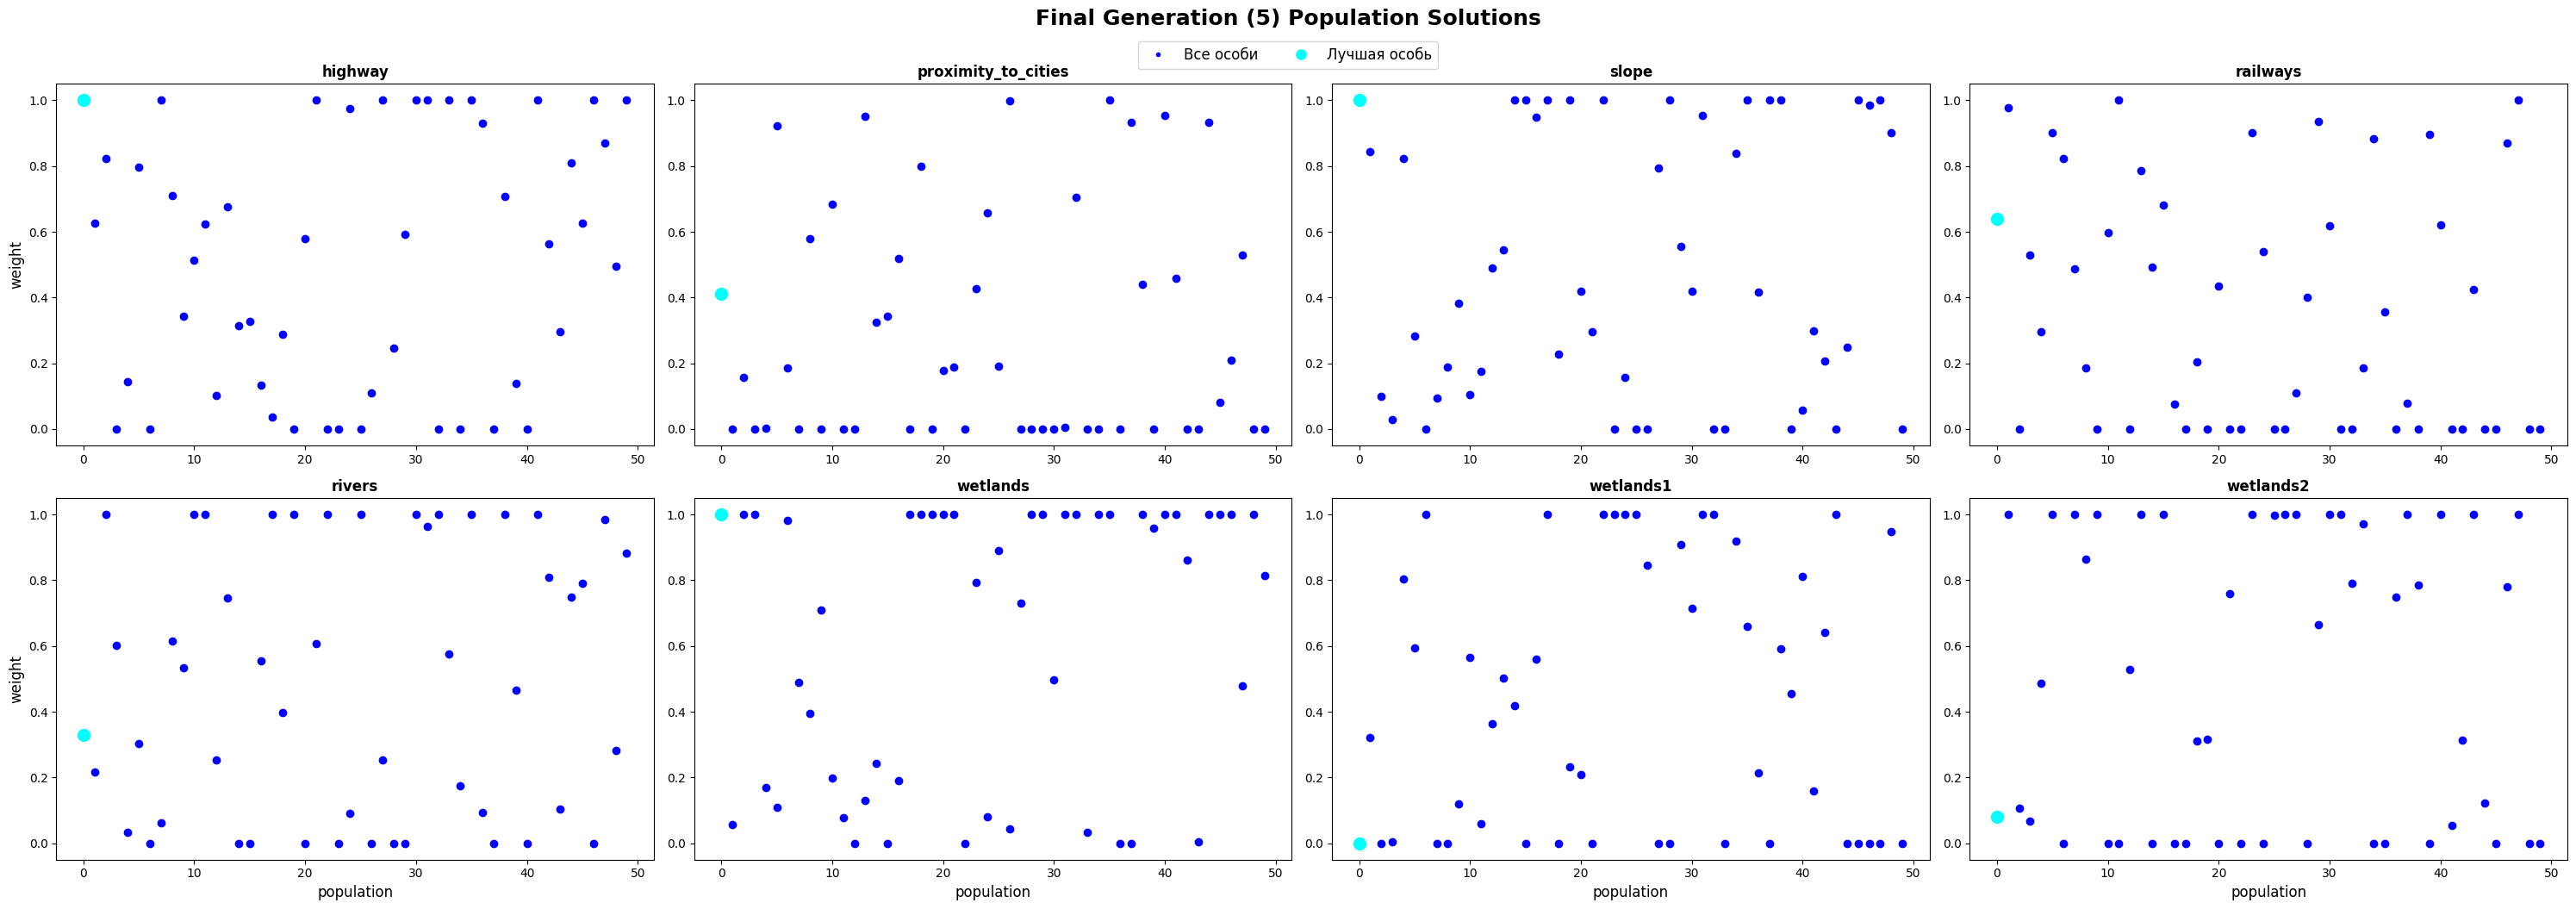

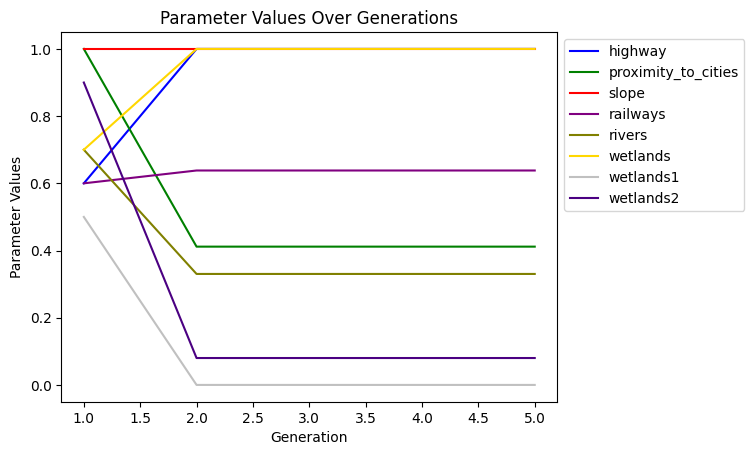

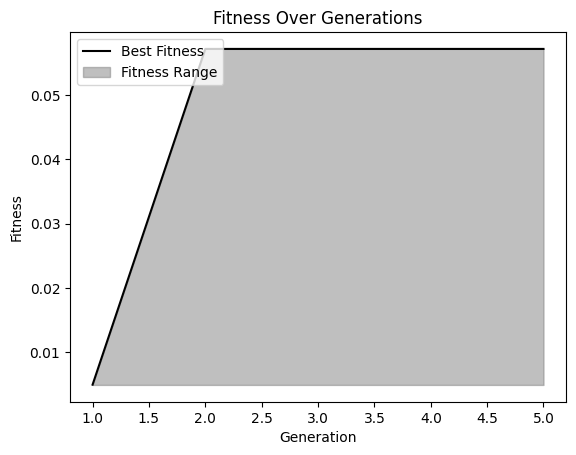

In [16]:
visualize_ga_results(table, all_populations, best_individual, generations, best_performers, worst_fitness)

Строю для сравнения полученный вариант

Start point: (647, 128), End point: (838, 1000)
Path found with total cost: 632.6415084369391


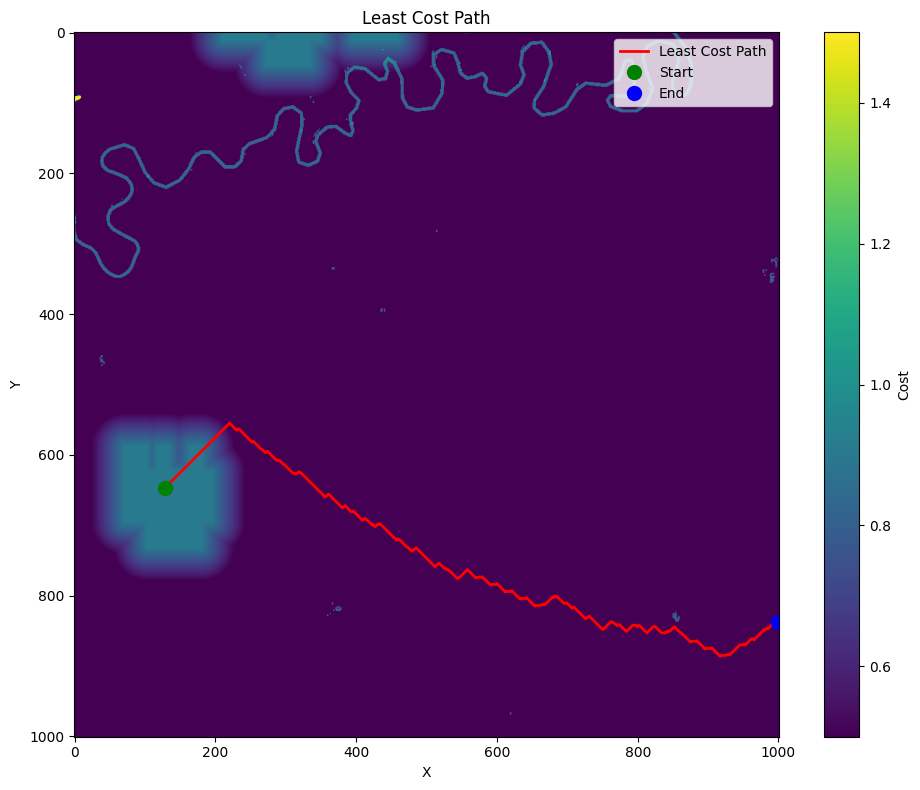

In [ ]:
# Для сравнения как оптимизировались веса (сравнение с обучающей трубой)
# cost_generator = CostMapGenerator(data_loader.factors)
# weight_mapping = None
# cost_map = cost_generator.generate_cost_map(weights=best_solution, default_weight=None, weight_mapping=weight_mapping)
# cost_map[cost_map == 0] = np.inf

# start_x, start_y = 9167986, 7388294 # 8536880, 9502543 - для ванкора
# end_x, end_y = 11568914, 6894631 # 8563026, 9496811- для ванкора

# start_indices = data_loader.coordinates_to_indices(start_x, start_y)
# end_indices = data_loader.coordinates_to_indices(end_x, end_y)

# Построение для областей интереса от Новосибирска до Красноярска и от Жигалово до Красноярска
final_datasets = ["datasets/roi1", "datasets/roi2"]

start_x_points_list =  {"datasets/roi1": 9245443,
                        "datasets/roi2": 11813503} 

start_y_points_list = {"datasets/roi1": 7359936,
                       "datasets/roi2":7436839} 

end_x_points_list = {"datasets/roi1": 10229816,
                     "datasets/roi2":10229816} 

end_y_points_list = {"datasets/roi1": 7548399,
                     "datasets/roi2":7548399}


dataset_path = "datasets/roi1" # в качестве первого привожу от новосибирска до красноярска

data_loader = DataLoader(dataset_path)
data_loader.load_data(factor_mapping=factor_mapping)
start_indices = data_loader.coordinates_to_indices(start_x_points_list[dataset_path], start_y_points_list[dataset_path])
end_indices = data_loader.coordinates_to_indices(end_x_points_list[dataset_path], end_y_points_list[dataset_path])
reference_path = load_reference_path(os.path.join(dataset_path, 'reference'))

cost_generator = CostMapGenerator(data_loader.factors)
weight_mapping = None
cost_map = cost_generator.generate_cost_map(weights=best_solution, default_weight=None, weight_mapping=weight_mapping)
cost_map[cost_map == 0] = np.inf

print(f"Start point: {start_indices}, End point: {end_indices}")

path_finder = LeastCostPathFinder(cost_map)
metadata = data_loader.get_common_metadata()
path_indices, path_cost = path_finder.find_path(
    start_indices, 
    end_indices, 
    method='astar',  
    fully_connected=True
)
print(f"Path found with total cost: {path_cost}")

# Visualize path on cost map
path_finder.visualize_path(path_indices, start_indices, end_indices)

# Convert path to GeoDataFrame (pass transform and crs here)
path_gdf = path_finder.path_to_geodataframe(
    path_indices, 
    path_cost, 
    transform=metadata['transform'], 
    crs=metadata['crs']
)

# Save path (optional)
path_output = os.path.join(dataset_path, 'results', 'least_cost_path.geojson')
path_gdf.to_file(path_output)

Path Comparison Metrics:
hausdorff_distance: 5652.2222
average_min_distance: 2472.7289
buffer_overlap: 0.0571
path_length_ratio: 1.2644
combined_score: 0.6989


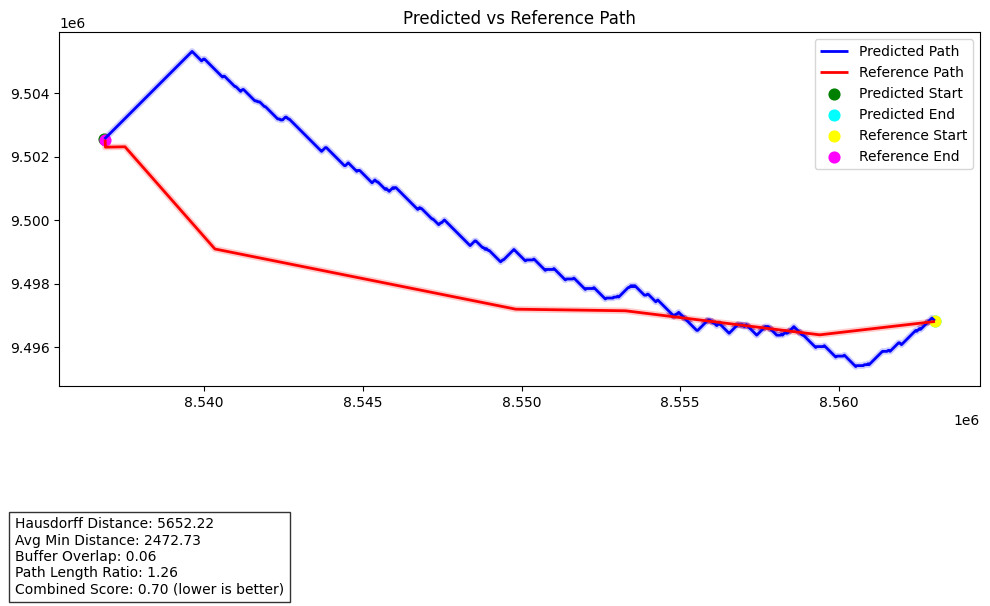

In [18]:
evaluator = PathEvaluator(
    predicted_path=path_indices,
    reference_path=reference_path,
    transform=metadata['transform'],
    crs=metadata['crs']
)

# Calculate all metrics
metrics = evaluator.evaluate_all_metrics(buffer_distance=100) # 3 км

# Display metrics
print("Path Comparison Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

# Visualize paths with metrics
evaluator.visualize_paths(title="Predicted vs Reference Path", buffer_distance=100)

# Genetic algorithm - вариант с обучением на нескольких изображениях

In [ ]:
# Датасет областей для обучения и точки начала и конца существующей трубы 
dataset_path_list = ["datasets/roi1_600k_300k_meters", "datasets/roi2_600k_300k_meters", "datasets/roi3_600k_300k_meters", "datasets/roi4_600k_300k_meters"] #["datasets/vankor_1k_1k_pixel", "datasets/vankor_1k_1k_pixel2"]
# data_loader_list = {} # словарь с data_loaders, где ключ путь к датасету
start_x_points_list =  {"datasets/roi1_600k_300k_meters": 9187144,
 "datasets/roi2_600k_300k_meters": 9779945,
 "datasets/roi3_600k_300k_meters":10388398,
 "datasets/roi4_600k_300k_meters":11000302} #{"datasets/vankor_1k_1k_pixel": 8536880, "datasets/vankor_1k_1k_pixel2": 8536880}

start_y_points_list = {"datasets/roi1_600k_300k_meters": 7397263,
 "datasets/roi2_600k_300k_meters":7596219,
 "datasets/roi3_600k_300k_meters":7551750,
 "datasets/roi4_600k_300k_meters":7364953} #{"datasets/vankor_1k_1k_pixel": 9502543, "datasets/vankor_1k_1k_pixel2": 9502543}

end_x_points_list = {"datasets/roi1_600k_300k_meters": 9767670,
 "datasets/roi2_600k_300k_meters":10378861,
 "datasets/roi3_600k_300k_meters":10987319,
 "datasets/roi4_600k_300k_meters":11418279} #{"datasets/vankor_1k_1k_pixel": 8563026, "datasets/vankor_1k_1k_pixel2": 8563026}

end_y_points_list = {"datasets/roi1_600k_300k_meters": 7597333,
 "datasets/roi2_600k_300k_meters":7561722,
 "datasets/roi3_600k_300k_meters":7409062,
 "datasets/roi4_600k_300k_meters":7073188} #{"datasets/vankor_1k_1k_pixel": 9496811, "datasets/vankor_1k_1k_pixel2": 9496811}

# reference_path_list = {}

factor_mapping = {
    'protectedMask.tif': 'protected_areas',
    'inverted_urban_zones.tif': 'proximity_to_cities',
    'slopeSuitability.tif': 'slope',
    'railwayMask.tif': 'railways',
    'riversMask.tif': 'rivers',
    'wetlandMask.tif': 'wetlands',
    'wetland1Mask.tif': 'wetlands1',
    'wetland2Mask.tif': 'wetlands2',
    'highwayMask.tif': 'highway',
}

# for dataset_path in dataset_path_list: # Паталась использовать подход, чтобы сразу несколько data_loaders хранилиссь в списвке, но из-за проблем с памятью, перешла к ваарианту, 
# когда на каждой итерации поколения считываются изображение - внутри ГА

#     data_loader_list[dataset_path] = DataLoader(dataset_path)
#     data_loader_list[dataset_path].load_data(factor_mapping=factor_mapping)
#     reference_path_list[dataset_path] =  load_reference_path(os.path.join(dataset_path, 'reference'))


In [4]:
import random
from prettytable import PrettyTable #python -m pip install prettytable

In [ ]:
def fitness_function(factors, params, start_indices, end_indices, reference_path, metadata):

    cost_generator = CostMapGenerator(factors)
    weight_mapping = None
    cost_map = cost_generator.generate_cost_map(weights=params, default_weight=None, weight_mapping=weight_mapping)
    cost_map[cost_map == 0] = np.inf

    path_finder = LeastCostPathFinder(cost_map)
    path_indices, path_cost = path_finder.find_path(start_indices, end_indices, method='astar',  fully_connected=True)

    evaluator = PathEvaluator(predicted_path=path_indices, reference_path=reference_path, 
                              transform=metadata['transform'],
                              crs=metadata['crs'])
    
    metrics = evaluator.calculate_buffer_overlap(buffer_distance = 100)

    return metrics

def create_initial_population(size, lower_bound, upper_bound): # стартовые веса
    population = []
    for _ in range(size):

        weights = { # не прописываю protected_areas - они всегда имеют коэфф 1
            'highway': 0.6,   
            'proximity_to_cities': 1, 
            'slope': 1,
            'railways': 0.6,          
            'rivers': 0.7,        
            'wetlands': 0.7,
            'wetlands1': 0.5,
            'wetlands2': 0.9,        
        }
        individual = (weights)
        population.append(individual)

    return population

# Selection function using tournament selection
def selection(population, fitnesses, tournament_size=5):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(zip(population, fitnesses)), tournament_size)
        winner = max(tournament, key=lambda x: x[1])[0]
        selected.append(winner)
    return selected

# Crossover function
def crossover(parent1, parent2):
    alpha = random.random()
    child1 = {}
    child2 = {}

    # Переписала через цикл, так как веса решила задавать словарем вместо массива
    for key in parent1:
        child1[key] = alpha * parent1[key] + (1 - alpha) * parent2[key]
        child2[key] = alpha * parent2[key] + (1 - alpha) * parent1[key]
    return child1, child2

# Mutation function
def mutation(individual, mutation_rate, lower_bound, upper_bound):
    mutated = individual.copy()
    
    for param in mutated:
        if random.random() < mutation_rate:
            
            mutation_amount = random.uniform(-1, 1)
            mutated[param] += mutation_amount

            mutated[param] = max(min(mutated[param], upper_bound), lower_bound)


    return mutated

# Main genetic algorithm function
def genetic_algorithm(dataset_path_list, factor_mapping, population_size, lower_bound, upper_bound, generations, mutation_rate,
                      start_x_points_list, start_y_points_list, end_x_points_list, end_y_points_list):
    population = create_initial_population(population_size, lower_bound, upper_bound)

    best_performers = []
    all_populations = []
    worst_fitness = []

    # Prepare for table
    table = PrettyTable()
    table.field_names = ["Generation", 'highway', 'proximity_to_cities',
                          'slope','railways','rivers','wetlands','wetlands1','wetlands2',
                          "Fitness"]

    for generation in range(generations):
        print('Generation №: ', generation)
        
        # Часть, где чередуется каждое поколение область для обучения
        dataset_path = dataset_path_list[generation % len(dataset_path_list)]
        print('dataset_path: ', dataset_path)
        data_loader = DataLoader(dataset_path)
        data_loader.load_data(factor_mapping=factor_mapping)
        factors =  data_loader.factors
        start_indices = data_loader.coordinates_to_indices(start_x_points_list[dataset_path], start_y_points_list[dataset_path])
        end_indices = data_loader.coordinates_to_indices(end_x_points_list[dataset_path], end_y_points_list[dataset_path])
        reference_path = load_reference_path(os.path.join(dataset_path, 'reference'))
        metadata = data_loader.get_common_metadata()

        fitnesses = [fitness_function(factors, ind, start_indices, end_indices, reference_path, metadata) for ind in population]
        
        # Store the best performer of the current generation
        best_idx = np.argmax(fitnesses)
        best_fitness = max(fitnesses)
        worst_fitness = min(fitnesses)
        best_individual = population[best_idx]
        best_performers.append((best_individual, max(fitnesses)))
        all_populations.append(population[:])
        table.add_row([generation + 1,
                        best_individual['highway'], best_individual['proximity_to_cities'], 
                        best_individual['slope'], best_individual['railways'], 
                        best_individual['rivers'], best_individual['wetlands'],
                        best_individual['wetlands1'], best_individual['wetlands2'],  
                        best_fitness])

        population = selection(population, fitnesses)

        next_population = []
        for i in range(0, len(population), 2):
            parent1 = population[i]
            parent2 = population[i + 1]

            crossover(parent1, parent2)
            child1, child2 = crossover(parent1, parent2)
            next_population.append(mutation(child1, mutation_rate, lower_bound, upper_bound))
            next_population.append(mutation(child2, mutation_rate, lower_bound, upper_bound))

            
        #Replace the old population with the new one, preserving the best individual
        next_population[0] = best_individual
        population = next_population

    return population[np.argmax(fitnesses)], table, all_populations, best_individual, best_performers, worst_fitness

In [ ]:
# Вынесла вывод после ГА в отдельную функцию
def visualize_ga_results(table, all_populations, best_individual, generations, best_performers, worst_fitness):

    print(table)

    fig, axs = plt.subplots(2, 4, figsize=(30, 10))

    # Последнее поколение значения весов фавторов
    final_population = all_populations[-1]
    
    factors_list = ['highway', 'proximity_to_cities','slope','railways','rivers','wetlands','wetlands1','wetlands2']# можно достать и из ind
    
    axs = axs.flatten()
    for i, el in enumerate(factors_list):
        axs[i].scatter(range(len(final_population)), [ind[el] for ind in final_population], color='blue', label=el)
        axs[i].scatter([final_population.index(best_individual)], [best_individual[el]], color='cyan', s=100, label='Best Individual {}'.format(el))
        axs[i].set_title(el, fontweight='bold')
        if i==0 or i==4:
            axs[i].set_ylabel('weight', fontsize=12)
        if i>=4:
            axs[i].set_xlabel('population', fontsize=12)

    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='Все особи'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='cyan', markersize=10, label='Лучшая особь')
    ]
    fig.legend(handles=legend_elements, 
           loc='upper center', 
           bbox_to_anchor=(0.5, 1.02),  # Размещаем над графиками
           ncol=2, fontsize=12)

    plt.tight_layout()

    fig.suptitle(f'Final Generation ({generations}) Population Solutions', fontsize=18, fontweight='bold', y=1.05)

    
   # Значения каждого параметра
    generations_list = range(1, len(best_performers) + 1)

    fig, ax = plt.subplots()
    
    colors_list = ['blue', 'green', 'red', 'purple', 'olive', 'gold', 'silver', 'indigo']
    for i, el in enumerate(factors_list):
        ax.plot(generations_list, [ind[0][el] for ind in best_performers], label=el, color=colors_list[i])

    ax.set_xlabel('Generation')
    ax.set_ylabel('Parameter Values')
    ax.set_title('Parameter Values Over Generations')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.show()

    # Значение метрики по поколениям 
    best_fitness_values = [fit[1] for fit in best_performers]
    min_fitness_values = worst_fitness
    max_fitness_values = best_fitness_values
    
    fig, ax = plt.subplots()
    ax.plot(generations_list, best_fitness_values, label='Best Fitness', color='black')
    ax.fill_between(generations_list, min_fitness_values, max_fitness_values, color='gray', alpha=0.5, label='Fitness Range')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness')
    ax.set_title('Fitness Over Generations')
    ax.legend(loc='upper left')

    plt.show()

In [ ]:
# Parameters for the genetic algorithm
population_size = 100 # Должно быть четным так как шаг 2 при создании потомков
lower_bound = 0.000001
upper_bound = 1
generations = 5
mutation_rate = 1


# Run the genetic algorithm
best_solution, table, all_populations, best_individual, best_performers, worst_fitness = genetic_algorithm(dataset_path_list, factor_mapping, population_size, lower_bound, upper_bound, generations, mutation_rate, start_x_points_list, start_y_points_list, end_x_points_list, end_y_points_list)
print(best_solution)

Generation №:  0
dataset_path:  datasets/vankor_1k_1k_pixel
Loaded 9 raster factors: ['highway', 'proximity_to_cities', 'protected_areas', 'railways', 'rivers', 'slope', 'wetlands1', 'wetlands2', 'wetlands']
Loaded reference path from datasets/vankor_1k_1k_pixel\reference\pipe.geojson
Generation №:  1
dataset_path:  datasets/vankor_1k_1k_pixel2
Loaded 9 raster factors: ['highway', 'proximity_to_cities', 'protected_areas', 'railways', 'rivers', 'slope', 'wetlands1', 'wetlands2', 'wetlands']
Loaded reference path from datasets/vankor_1k_1k_pixel2\reference\pipe.geojson
Generation №:  2
dataset_path:  datasets/vankor_1k_1k_pixel
Loaded 9 raster factors: ['highway', 'proximity_to_cities', 'protected_areas', 'railways', 'rivers', 'slope', 'wetlands1', 'wetlands2', 'wetlands']
Loaded reference path from datasets/vankor_1k_1k_pixel\reference\pipe.geojson
Generation №:  3
dataset_path:  datasets/vankor_1k_1k_pixel2
Loaded 9 raster factors: ['highway', 'proximity_to_cities', 'protected_areas', 

+------------+---------+---------------------+-------+--------------------+--------------------+----------+-----------+-----------+----------------------+
| Generation | highway | proximity_to_cities | slope |      railways      |       rivers       | wetlands | wetlands1 | wetlands2 |       Fitness        |
+------------+---------+---------------------+-------+--------------------+--------------------+----------+-----------+-----------+----------------------+
|     1      |   0.6   |          1          |   1   |        0.6         |        0.7         |   0.7    |    0.5    |    0.9    | 0.004988007634337018 |
|     2      |    1    |  0.4042218030948548 |   1   | 0.6528417926289295 | 0.6682447448709636 |    1     |     1     |     1     | 0.05714668948561461  |
|     3      |    1    |  0.4042218030948548 |   1   | 0.6528417926289295 | 0.6682447448709636 |    1     |     1     |     1     | 0.05714668948561461  |
|     4      |    1    |  0.4042218030948548 |   1   | 0.6528417926289

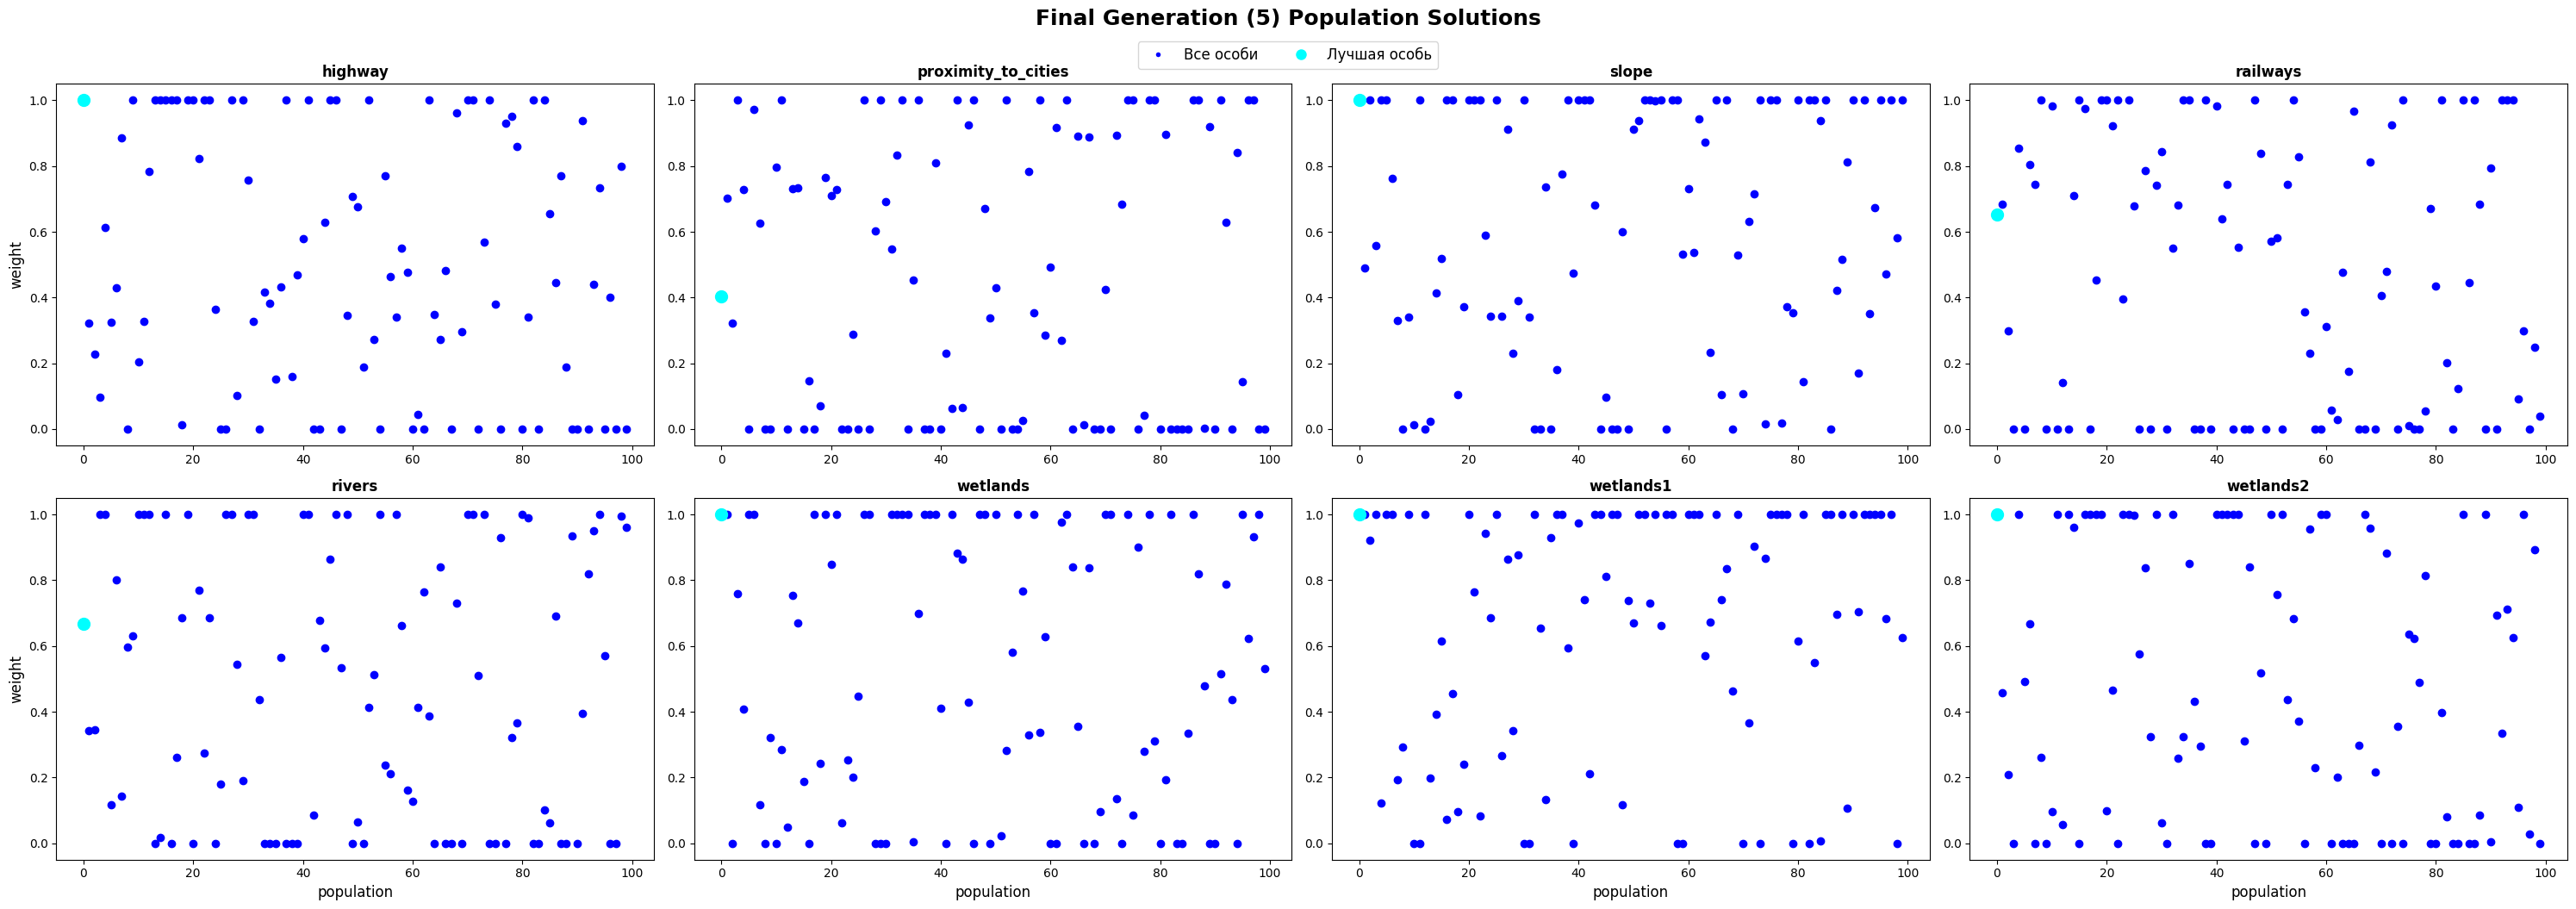

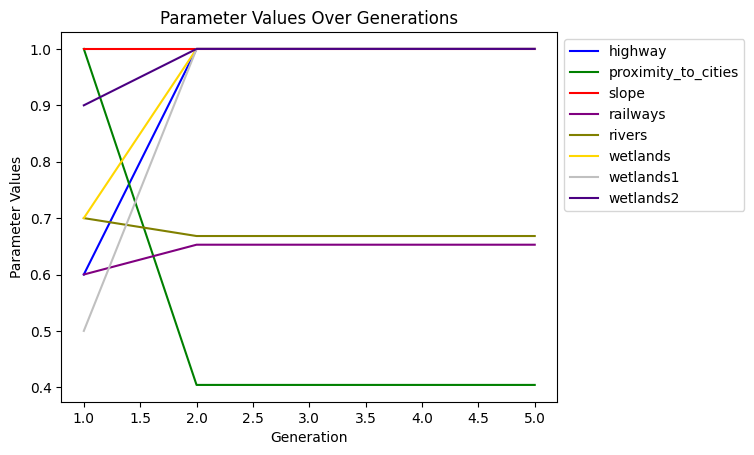

In [ ]:
visualize_ga_results(table, all_populations, best_individual, generations, best_performers, worst_fitness)

In [ ]:
# Для построения финального пути с новыми коэффициентами - вариант, если сравнивать поданный маршрут и построенный
# dataset_path = "datasets/roi1_600k_300k_meters"
# data_loader = DataLoader(dataset_path)
# data_loader.load_data(factor_mapping=factor_mapping)
# start_indices = data_loader.coordinates_to_indices(start_x_points_list[dataset_path], start_y_points_list[dataset_path])
# end_indices = data_loader.coordinates_to_indices(end_x_points_list[dataset_path], end_y_points_list[dataset_path])
# reference_path = load_reference_path(os.path.join(dataset_path, 'reference'))

# Построение для областей интереса от Новосибирска до Красноярска и от Жигалово до Красноярска
final_datasets = ["datasets/roi1", "datasets/roi2"]

start_x_points_list =  {"datasets/roi1": 9245443,
                        "datasets/roi2": 11813503} 

start_y_points_list = {"datasets/roi1": 7359936,
                       "datasets/roi2":7436839} 

end_x_points_list = {"datasets/roi1": 10229816,
                     "datasets/roi2":10229816} 

end_y_points_list = {"datasets/roi1": 7548399,
                     "datasets/roi2":7548399}


dataset_path = "datasets/roi1" # в качестве первого привожу от новосибирска до красноярска

data_loader = DataLoader(dataset_path)
data_loader.load_data(factor_mapping=factor_mapping)
start_indices = data_loader.coordinates_to_indices(start_x_points_list[dataset_path], start_y_points_list[dataset_path])
end_indices = data_loader.coordinates_to_indices(end_x_points_list[dataset_path], end_y_points_list[dataset_path])
reference_path = load_reference_path(os.path.join(dataset_path, 'reference'))

cost_generator = CostMapGenerator(data_loader.factors)
weight_mapping = None
cost_map = cost_generator.generate_cost_map(weights=best_solution, default_weight=None, weight_mapping=weight_mapping)
cost_map[cost_map == 0] = np.inf

print(f"Start point: {start_indices}, End point: {end_indices}")

path_finder = LeastCostPathFinder(cost_map)
metadata = data_loader.get_common_metadata()
path_indices, path_cost = path_finder.find_path(
    start_indices, 
    end_indices, 
    method='astar',  
    fully_connected=True 
)
print(f"Path found with total cost: {path_cost}")

# Visualize path on cost map
path_finder.visualize_path(path_indices, start_indices, end_indices)

# Convert path to GeoDataFrame (pass transform and crs here)
path_gdf = path_finder.path_to_geodataframe(
    path_indices, 
    path_cost, 
    transform=metadata['transform'], 
    crs=metadata['crs']
)

# Save path (optional)
path_output = os.path.join(dataset_path, 'results', 'least_cost_path.geojson')
path_gdf.to_file(path_output)

In [ ]:
evaluator = PathEvaluator(
    predicted_path=path_indices,
    reference_path=reference_path,
    transform=metadata['transform'],
    crs=metadata['crs']
)

# Calculate all metrics
metrics = evaluator.evaluate_all_metrics(buffer_distance=100) # 3 км

# Display metrics
print("Path Comparison Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

# Visualize paths with metrics
evaluator.visualize_paths(title="Predicted vs Reference Path", buffer_distance=100)

# Объединение нескольких растров в один

In [ ]:
# datasets/interest_area
tile_paths1 =['datasets/interest_area/factors/slopeSuitability-0000000000-0000000000.tif',
             'datasets/interest_area/factors/slopeSuitability-0000000000-0000065536.tif'] # перечислить файлы, которые надо объединить
output_path1 = 'datasets/interest_area/factors/slopeSuitability.tif'

tile_paths2 =['datasets/interest_area/factors/highwayMask-0000000000-0000000000.tif',
             'datasets/interest_area/factors/highwayMask-0000000000-0000065536.tif'] 
output_path2 = 'datasets/interest_area/factors/highwayMask.tif'

tile_paths3 =['datasets/interest_area/factors/riversMask-0000000000-0000000000.tif',
             'datasets/interest_area/factors/riversMask-0000000000-0000065536.tif'] 
output_path3 = 'datasets/interest_area/factors/riversMask.tif'

tile_paths4 =['datasets/interest_area/factors/railwayMask-0000000000-0000000000.tif',
             'datasets/interest_area/factors/railwayMask-0000000000-0000065536.tif'] 
output_path4 = 'datasets/interest_area/factors/railwayMask.tif'

tile_paths5 =['datasets/interest_area/factors/wetlandMask-0000000000-0000000000.tif',
             'datasets/interest_area/factors/wetlandMask-0000000000-0000065536.tif'] 
output_path5 = 'datasets/interest_area/factors/wetlandMask.tif'

tile_paths6 =['datasets/interest_area/factors/wetland1Mask-0000000000-0000000000.tif',
             'datasets/interest_area/factors/wetland1Mask-0000000000-0000065536.tif'] 
output_path6 = 'datasets/interest_area/factors/wetland1Mask.tif'

tile_paths7 =['datasets/interest_area/factors/wetland2Mask-0000000000-0000000000.tif',
             'datasets/interest_area/factors/wetland2Mask-0000000000-0000065536.tif'] 
output_path7 = 'datasets/interest_area/factors/wetland2Mask.tif'

tile_paths8 =['datasets/interest_area/factors/inverted_urban_zones-0000000000-0000000000.tif',
             'datasets/interest_area/factors/inverted_urban_zones-0000000000-0000065536.tif'] 
output_path8 = 'datasets/interest_area/factors/inverted_urban_zones.tif'

tile_paths9 =['datasets/interest_area/factors/protectedMask-0000000000-0000000000.tif',
             'datasets/interest_area/factors/protectedMask-0000000000-0000065536.tif'] 
output_path9 = 'datasets/interest_area/factors/protectedMask.tif'

In [28]:
import rasterio
from rasterio.merge import merge

In [ ]:
# Открываю все тайлы и сохраняю в список
src_files = [rasterio.open(fp) for fp in tile_paths1]

# Объединяю тайлы
mosaic, out_transform = merge(src_files)

# Закрываю все исходные файлы
for src in src_files:
    src.close()

print("Форма объединенного растра:", mosaic.shape)

with rasterio.open(tile_paths1[0]) as src:
    meta = src.meta.copy()

# Обновляю метаданные для mosaic
meta.update({
    'driver': 'GTiff',
    'height': mosaic.shape[1],
    'width': mosaic.shape[2],
    'transform': out_transform,
    'count': mosaic.shape[0],  # Количество каналов
    'dtype': mosaic.dtype
})

# Сохраняю в файл
output_path = output_path1
with rasterio.open(output_path, 'w', compress='lzw', **meta) as dst:
    dst.write(mosaic)

MemoryError: Unable to allocate 6.85 GiB for an array with shape (1, 28078, 65536) and data type float32

Все-таки столкнулась с проблемой по памяти, поэтому перечисляю рядом с tile_paths файлы для объединения и их название после объединения 